# Using kmeans clustering to identify a small subset of labelled images to seed the classification process for Fashion MNIST dataset
## -Avirup Das [MDS202013]
## -Ayush Thada [MDS202014]

In [ ]:
%load_ext memory_profiler

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses, metrics, callbacks, datasets
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from joblib import dump, load
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
seed=42
tf.random.set_seed(seed)

# Loading and Preprocessing Data

In [ ]:
(X_train,y_train),(X_test,y_test)=datasets.fashion_mnist.load_data()
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
            'Sneaker','Bag','Ankle Boot']
# Normalizing
X_train, X_test= X_train/255.0, X_test/255.0

# Checking shape of the data
print(f"X-train shape: {X_train.shape}")
print(f"y-train shape: {y_train.shape}")
print(f"X-test shape: {X_test.shape}")
print(f"y-test shape: {y_test.shape}")

# Flattening data for Logistic Regression
X_train_flatten= X_train.reshape(X_train.shape[0],-1)
y_train_flatten= y_train.reshape(y_train.shape[0],-1)
X_test_flatten= X_test.reshape(X_test.shape[0],-1)
y_test_flatten= y_test.reshape(y_test.shape[0],-1)

X-train shape: (60000, 28, 28)
y-train shape: (60000,)
X-test shape: (10000, 28, 28)
y-test shape: (10000,)


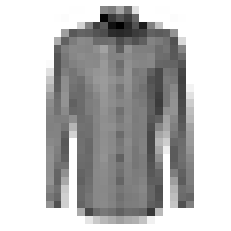

It is a  Shirt


In [ ]:
index=3000
plt.imshow(X_train[index],cmap='binary')
plt.axis('off')
plt.show()

print('It is a ',class_names[y_train[index]])

# Experimenting with Logistic Regression

## On original data

In [ ]:
%%time
%%memit
log_reg1 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg1.fit(X_train_flatten, y_train_flatten.ravel())

peak memory: 3220.67 MiB, increment: 0.00 MiB
CPU times: user 31min 35s, sys: 4.14 s, total: 31min 40s
Wall time: 31min 43s


In [ ]:
dump(log_reg1,'log_reg_orig.joblib')
log_reg1.score(X_test_flatten, y_test_flatten)

0.841

In [ ]:
%%time
%%memit
k=[100,200,300]
pipeline=np.empty(len(k),dtype=object)
for i in range(len(k)):
    pipeline[i] = Pipeline([("kmeans", KMeans(init='k-means++',n_clusters=k[i], random_state=seed)),
                         ("log_reg", LogisticRegression(multi_class="ovr", solver="saga",
                                                        max_iter=5000, random_state=seed))])
    pipeline[i].fit(X_train_flatten, y_train_flatten.ravel())
    dump(pipeline[i],'log_reg_kmeans_{}.joblib'.format(i))
    print('Cluster= {}, Accuracy= {}'.format(k[i],
            pipeline[i].score(X_test_flatten,y_test_flatten)))

Cluster= 100, Accuracy= 0.8262
Cluster= 200, Accuracy= 0.8389
Cluster= 300, Accuracy= 0.8456
peak memory: 6364.94 MiB, increment: 3626.22 MiB
CPU times: user 3h 16min 20s, sys: 2min 29s, total: 3h 18min 49s
Wall time: 2h 47min 38s


## Random Labelled Instances

In [ ]:
%%time
%%memit
k=[500,1000,2000]
log_reg2=np.empty(len(k),dtype=object)
for i in range(len(k)):
    log_reg2[i] = LogisticRegression(multi_class="ovr", solver="saga", random_state=seed)
    log_reg2[i].fit(X_train_flatten[:k[i]], y_train_flatten[:k[i]].ravel())
    dump(log_reg2[i],'log_reg_few_label_{}.joblib'.format(i))
    print('Labelled Instance= {}, Accuracy= {}'.format(k[i],
            log_reg2[i].score(X_test_flatten,y_test_flatten.ravel())))

Labelled Instance= 500, Accuracy= 0.7852
Labelled Instance= 1000, Accuracy= 0.7924
Labelled Instance= 2000, Accuracy= 0.8089
peak memory: 1732.44 MiB, increment: 7.16 MiB
CPU times: user 17.2 s, sys: 518 ms, total: 17.7 s
Wall time: 15 s


In [ ]:
%%time
%%memit
kmeans1 = KMeans(init='k-means++',n_clusters=2000, random_state=seed)
X_items_dist = kmeans1.fit_transform(X_train_flatten)
dump(kmeans1,'kmeans_2000.joblib')
representative_items_idx = np.argmin(X_items_dist, axis=0)
X_representative_items = X_train_flatten[representative_items_idx]
y_representative_items = np.squeeze(y_train_flatten[representative_items_idx]).astype('int32')

peak memory: 10396.50 MiB, increment: 8859.62 MiB
CPU times: user 1h 32min 8s, sys: 7min 11s, total: 1h 39min 19s
Wall time: 16min 9s


In [ ]:
y_representative_items = np.squeeze(y_train_flatten[representative_items_idx]).astype('int32')
print(np.array(class_names)[y_representative_items])

['Ankle Boot' 'T-shirt/top' 'T-shirt/top' ... 'Bag' 'Trouser' 'Ankle Boot']


## Using These Centroids to fit logistic regression

In [ ]:
%%time
%%memit
log_reg3 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg3.fit(X_representative_items, y_representative_items)
dump(log_reg3,'log_reg_centroids.joblib')
print('Accuracy= ',log_reg3.score(X_test_flatten, y_test_flatten))

Accuracy=  0.8146
peak memory: 8181.33 MiB, increment: 0.03 MiB
CPU times: user 59.9 s, sys: 160 ms, total: 1min
Wall time: 1min


## Clustering and Propgating Labels to each Data Point

In [ ]:
y_train_propagated = np.empty(len(X_train_flatten), dtype=np.int32)
for i in range(2000):
    y_train_propagated[kmeans1.labels_==i] = y_representative_items[i]

In [ ]:
%%time
%%memit
log_reg4 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg4.fit(X_train_flatten, y_train_propagated)
dump(log_reg4,'log_reg_propagated.joblib')
print(log_reg4.score(X_test_flatten,y_test_flatten))

0.8121
peak memory: 8182.73 MiB, increment: 0.02 MiB
CPU times: user 32min 4s, sys: 3.96 s, total: 32min 8s
Wall time: 32min 11s


## Clustering and Propgating Labels to Data Points Closer to Cluster Centroids

In [ ]:
%%time
%%memit
percentile_closest = 25

X_cluster_dist = X_items_dist[np.arange(len(X_train_flatten)), kmeans1.labels_]
for i in range(2000):
    in_cluster = (kmeans1.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

peak memory: 3609.66 MiB, increment: 895.62 MiB
CPU times: user 264 ms, sys: 262 ms, total: 526 ms
Wall time: 646 ms


In [ ]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train_flatten[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
%%time
%%memit
log_reg5 = LogisticRegression(multi_class="ovr", solver="saga", max_iter=5000, random_state=seed)
log_reg5.fit(X_train_partially_propagated, y_train_partially_propagated)
dump(log_reg5,'log_reg_partially_propagated.joblib')
print(log_reg5.score(X_test_flatten,y_test_flatten))

0.8044
peak memory: 4021.36 MiB, increment: 0.03 MiB
CPU times: user 7min 15s, sys: 737 ms, total: 7min 16s
Wall time: 7min 16s


# Experimenting with Neural Networks

## Utility

In [ ]:
def get_model(input_shape=(28,28, 1), n_class=10):
    model = models.Sequential([
                               layers.InputLayer(input_shape=input_shape),
                               layers.Conv2D(32, (3, 3), activation="relu"),
                               layers.Conv2D(64, (3, 3), activation="relu"),
                               layers.Conv2D(128, (3, 3), activation="relu"),
                               layers.Conv1D(1, 1, activation="relu"),
                               layers.Flatten(),
                               layers.Dense(64, activation='relu'),
                               layers.Dense(10, activation="sigmoid")
    ])

    model.compile(loss=losses.SparseCategoricalCrossentropy(name="loss"), 
                  optimizer="adam",
                  metrics=["accuracy"])
    
    return model

def train_model(model, x_data, y_data, patience=8, batch_size=32):
    estop = callbacks.EarlyStopping(patience=patience)
    history = model.fit(x_data[..., np.newaxis], 
                        y_data, 
                        batch_size = batch_size, 
                        epochs = 100,
                        verbose = 1,
                        validation_split = 0.1,
                        callbacks = [estop])
    return history.history

## On Original Data

In [ ]:
%%time
%%memit

model_1 = get_model()
display(plot_model(model_1, rankdir="LR", show_shapes=True, show_layer_names=False))

# Train Model
history_1 = train_model(model_1, X_train, y_train);
# Testing Evaluation
model_1.evaluate(X_test[..., np.newaxis], y_test);
model_1.save('nn_original')

## Random Labelled Instances

In [ ]:
%%time
%%memit

k=[500,1000,2000]
model_2,history_2=np.empty(len(k),dtype=object),np.empty(len(k),dtype=object)
for i in range(len(k)):
    model_2[i]=get_model()
    history_2[i]=train_model(model_2[i], X_train[:k[i]][..., np.newaxis], y_train[:k[i]])
    model_2[i].evaluate(X_test[..., np.newaxis], y_test);
    model_2[i].save('nn_labelled_{}'.format(k[i]))

# Clustering and Using Centroids as Representative

In [ ]:
%%time
%%memit

k=[500,1000,2000]
kmeans_2=np.empty(len(k),dtype=object)
model_3,history_3=np.empty(len(k),dtype=object),np.empty(len(k),dtype=object)
for i in range(len(k)):
    kmeans_2[i] = KMeans(init='k-means++',n_clusters = k[i], random_state = seed)
    X_items_dist = kmeans_2[i].fit_transform(X_train.reshape(X_train.shape[0], -1))
    representative_items_idx = np.argmin(X_items_dist, axis=0)
    X_representative_items = X_train[representative_items_idx]
    y_representative_items = y_train[representative_items_idx]
    
    model_3[i]=get_model()
    history_3[i]= train_model(model_3[i], X_representative_items[..., np.newaxis], y_representative_items)
    model_3[i].evaluate(X_test[..., np.newaxis], y_test);
    model_3[i].save('nn_centroid_cluster_{}'.format(k[i]))
    dump(kmeans_2[i],'cluster_nn_{}.joblib'.format(k[i]))

## Clustering and Propgating Labels to each Data Point

In [ ]:
def cluster_label_prop(k=500):
    kmeans=load('cluster_nn_{}.joblib'.format(k))
    X_items_dist=kmeans.transform(X_train.reshape(X_train.shape[0], -1))
    representative_items_idx = np.argmin(X_items_dist, axis=0)
    X_representative_items = X_train[representative_items_idx]
    y_representative_items = y_train[representative_items_idx]
    y_train_propagated = np.empty(len(X_train), dtype=np.int32)
    for i in range(k):
        y_train_propagated[kmeans.labels_==i] = y_representative_items[i]
    
    #construct and train fresh neural network
    model_4=get_model()
    history_4 = train_model(model_4, X_train[..., np.newaxis], y_train_propagated)
    model_4.evaluate(X_test[..., np.newaxis], y_test);
    model_4.save('nn_full_propagated_{}'.format(k))

In [ ]:
%%time
%%memit

for i in k:
    print('Clusters: ',i)
    cluster_label_prop(i)

## Clustering and Propgating Labels to Data Points Closer to Cluster Centroids

In [ ]:
def cluster_label_prop(k=500,percentile_closest=25):
    kmeans=load('cluster_nn_{}.joblib'.format(k))
    X_items_dist=kmeans.transform(X_train.reshape(X_train.shape[0], -1))
    X_cluster_dist = X_items_dist[np.arange(len(X_train)), kmeans.labels_]
    representative_items_idx = np.argmin(X_items_dist, axis=0)
    y_representative_items = y_train[representative_items_idx]
    y_train_propagated = np.empty(len(X_train), dtype=np.int32)
    for i in range(k):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
        y_train_propagated[kmeans.labels_==i] = y_representative_items[i]
        
    # Allocating Labels to Marked Point in Cluster
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = X_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]
    
    #construct and train fresh neural network
    model_5=get_model()
    history_5 = train_model(model_5, X_train_partially_propagated[..., np.newaxis], y_train_partially_propagated)
    model_5.evaluate(X_test[..., np.newaxis], y_test);
    model_5.save('nn_partially_propagated_{}-clusters_{}-percentile'.format(k,percentile_closest))

In [ ]:
%%time
%%memit

for i in k:
    print('Clusters: ',i)
    cluster_label_prop(i)

## Taking 2000 clusters and determining optimum percentile for propagation

In [ ]:
%%time
%%memit

for i in [20,25,30,50,75]:
    print('Percentile= ',i)
    cluster_label_prop(k=2000,percentile_closest=i)